# 6. Using machine learning model to predict the ILC residual

In reality, we don't know the true CMB signal. However, we can still compute the ILC estimation of the CMB signal. 

This Machine Learning model is using simulated data to learn to predict the ILC residual. 

The last step is to subtract the ILC residual from the ILC estimation. 

6.1 Define the machine learning classes

In [ ]:
!pip isntall torch
!pip isntall torchvision
!pip install tqdm

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
# Convolution block
class DoubleConv(nn.Module):
    """
        A convolutional block that applies two sequential convolutional layers followed by ReLU activation.

        Args:
        -----
        in_channels (int): Number of input channels for the convolutional layers.
        out_channels (int): Number of output channels after the convolutional layers.

        Methods:
        --------
        forward(x):
            Applies the two convolutional layers and returns the transformed tensor.
        
    """
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

# Downsample block
class DownSample(nn.Module):
    """
        A downsampling block consisting of a DoubleConv block followed by MaxPooling.

        Args:
        -----
        in_channels (int): Number of input channels for the DoubleConv block.
        out_channels (int): Number of output channels after the DoubleConv block.

        Methods:
        --------
        forward(x):
            Applies the DoubleConv block and MaxPooling, returning both the output of DoubleConv and the pooled output.
        
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

# Upsample block
class UpSample(nn.Module):
    """
        An upsampling block that upsamples the input tensor and applies a DoubleConv block.

        Args:
        -----
        in_channels (int): Number of input channels before upsampling.
        out_channels (int): Number of output channels after the DoubleConv block.

        Methods:
        --------
        forward(x1, x2):
            Upsamples x1 and concatenates it with x2, then applies the DoubleConv block. Returns the transformed tensor.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], dim=1)
       return self.conv(x)

# UNet model
class UNet(nn.Module):
    """
        A UNet architecture implementation for image segmentation tasks.

        Args:
        -----
        in_channels (int): Number of input channels for the first layer.
        num_classes (int): Number of output channels.

        Methods:
        --------
        forward(x):
            Passes the input through the UNet architecture and returns the final ILC redsidual prediction.
        
    """
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)
        self.bottle_neck = DoubleConv(512, 1024)
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)
        b = self.bottle_neck(p4)
        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)
        out = self.out(up_4)
        return out




class CMB_Dataset(Dataset):
    """
        A custom dataset class for the CMB dataset.

        Args:
        -----
        root_path (str): Path to the root directory containing the dataset.
        test (bool): If True, loads the test dataset. Otherwise, loads the training dataset.

        Methods:
        --------
        __getitem__(index):
            Returns the image and mask at the specified index.
        
        __len__():
            Returns the number of images in the dataset
    """
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        folder = "test_data" if test else "train_data"
        mask_folder = "test_masks" if test else "train_masks"
        self.images = sorted([os.path.join(root_path, folder, i) for i in os.listdir(os.path.join(root_path, folder))])
        self.masks = sorted([os.path.join(root_path, mask_folder, i) for i in os.listdir(os.path.join(root_path, mask_folder))])
        self.transform = transforms.Compose([transforms.ToTensor()])  # Converts data to torch.float32

    def __getitem__(self, index):
        img_paths = self.images[index]

        # the data is stored as (9, 256, 256) 
        # 9 frequencies, 256x256 images
        # In pytorch the channel is usually the last dimension
        # swap the axes to make it (256, 256, 9)
        img = np.load(img_paths).swapaxes(0,1).swapaxes(1,2)
    
        mask_path = self.masks[index]
        mask = np.load(mask_path)

        img, mask = self.transform(img), self.transform(mask)
        return img.float(), mask.float()

    def __len__(self):
        return len(self.images)

### 6.2 Machine Learning training steps:

1. Set Hyperparameters and Paths:
    - Define LEARNING_RATE, BATCH_SIZE, EPOCHS, DATA_PATH, MODEL_SAVE_PATH, and device.
2. Prepare the Dataset:
    - Load the dataset using CMB_Dataset class and split into training and validation sets.
    - Create DataLoader objects for efficient data loading.
3. Initialize the Model, Loss Function, and Optimizer:
    - Initialize UNet model, loss function (BCEWithLogitsLoss), and optimizer (Adam).
4. Training Loop:
    - Iterate over epochs, performing training and validation in each epoch.
    - For training: Forward pass, calculate loss, backpropagate, and optimize.
    - For validation: Evaluate model performance, visualize predictions, and calculate validation loss.
    - Log the loss values after each epoch.
5. Save the Model:
    - Save the trained model state to the defined path.


100%|██████████| 6/6 [00:00<00:00, 46.68it/s]


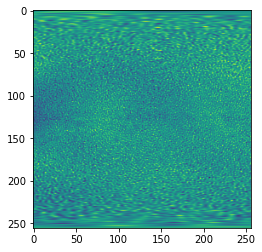

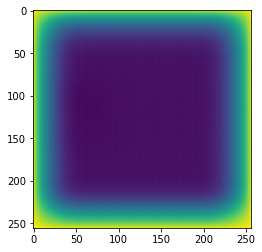

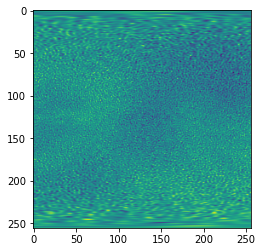

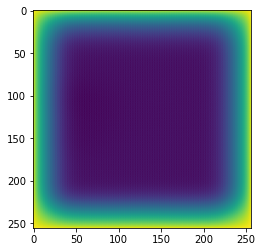

100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


------------------------------
Train Loss EPOCH 1: 127358.9065
Valid Loss EPOCH 1: -0.1019
------------------------------


100%|██████████| 6/6 [00:00<00:00, 46.98it/s]


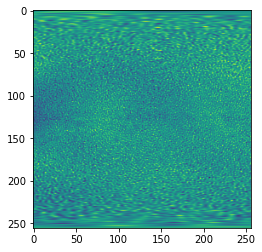

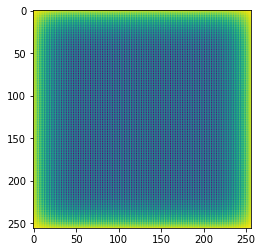

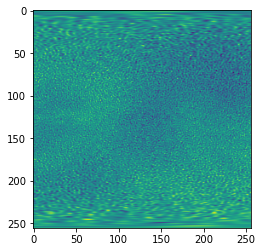

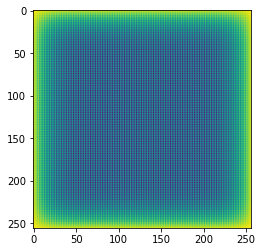

100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


------------------------------
Train Loss EPOCH 2: 0.1295
Valid Loss EPOCH 2: -0.0172
------------------------------


100%|██████████| 6/6 [00:00<00:00, 48.35it/s]


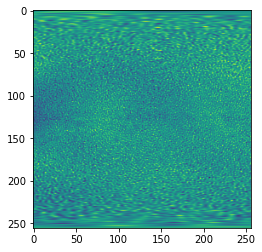

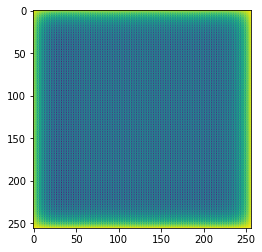

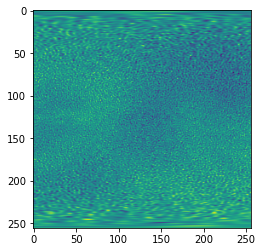

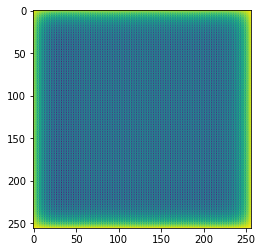

100%|██████████| 2/2 [00:00<00:00,  7.13it/s]


------------------------------
Train Loss EPOCH 3: 1.1945
Valid Loss EPOCH 3: 0.0002
------------------------------


100%|██████████| 6/6 [00:00<00:00, 48.46it/s]


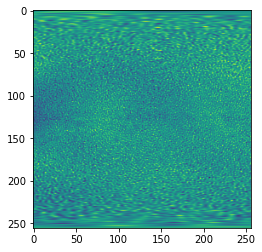

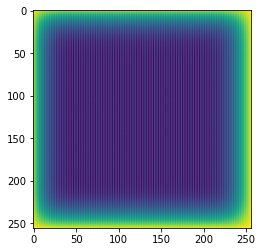

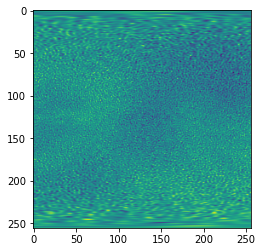

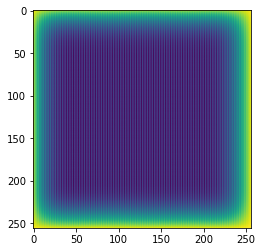

100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


------------------------------
Train Loss EPOCH 4: 0.0076
Valid Loss EPOCH 4: -0.0029
------------------------------


100%|██████████| 6/6 [00:00<00:00, 48.52it/s]


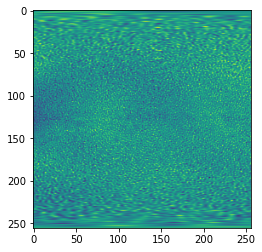

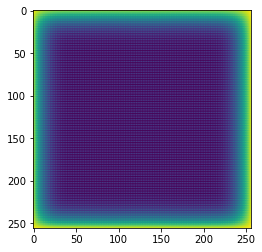

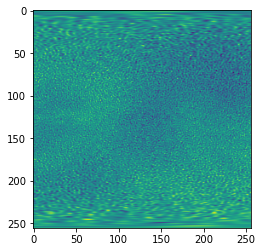

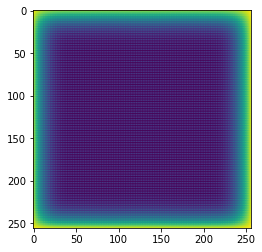

100%|██████████| 2/2 [00:00<00:00,  7.19it/s]


------------------------------
Train Loss EPOCH 5: 0.0029
Valid Loss EPOCH 5: -0.0016
------------------------------


100%|██████████| 6/6 [00:00<00:00, 48.36it/s]


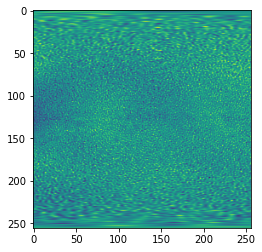

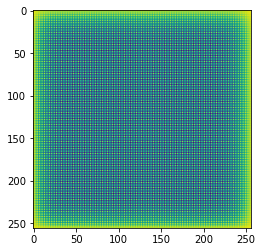

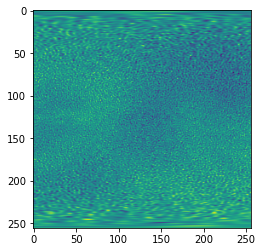

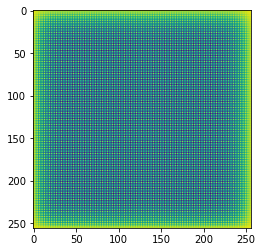

100%|██████████| 2/2 [00:00<00:00,  7.31it/s]


------------------------------
Train Loss EPOCH 6: 0.0013
Valid Loss EPOCH 6: 0.0385
------------------------------


100%|██████████| 6/6 [00:00<00:00, 47.93it/s]


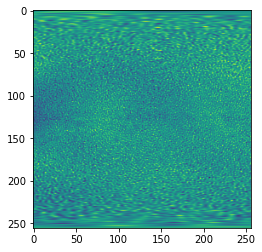

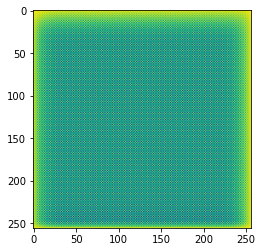

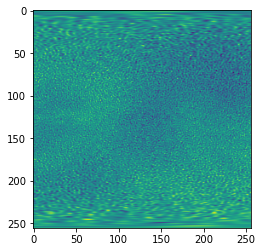

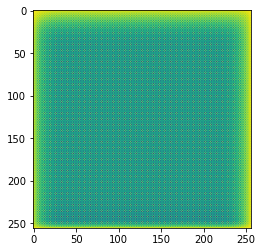

100%|██████████| 2/2 [00:00<00:00,  7.31it/s]


------------------------------
Train Loss EPOCH 7: 0.0072
Valid Loss EPOCH 7: -0.0006
------------------------------


100%|██████████| 6/6 [00:00<00:00, 48.11it/s]


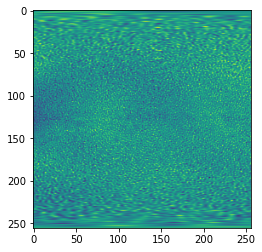

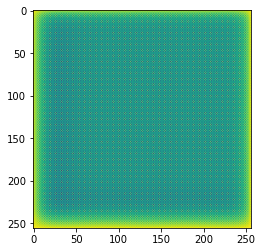

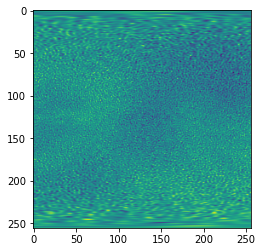

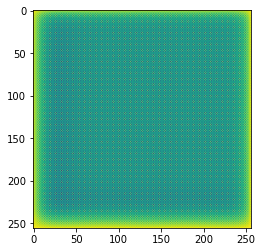

100%|██████████| 2/2 [00:00<00:00,  7.21it/s]


------------------------------
Train Loss EPOCH 8: 0.0008
Valid Loss EPOCH 8: -0.0007
------------------------------


100%|██████████| 6/6 [00:00<00:00, 48.53it/s]


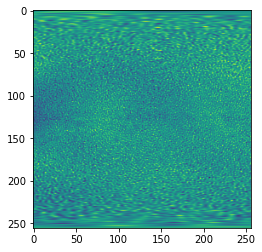

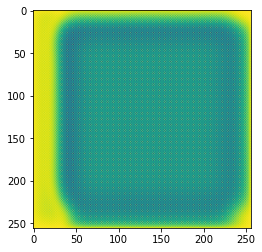

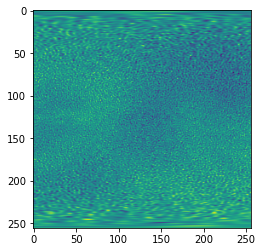

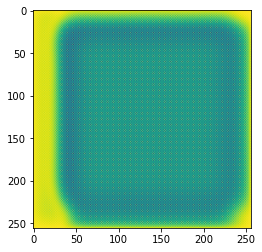

100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


------------------------------
Train Loss EPOCH 9: 0.0005
Valid Loss EPOCH 9: -0.0024
------------------------------


100%|██████████| 6/6 [00:00<00:00, 48.29it/s]


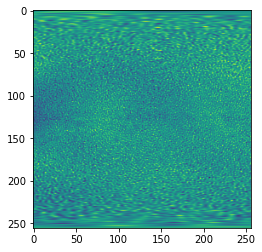

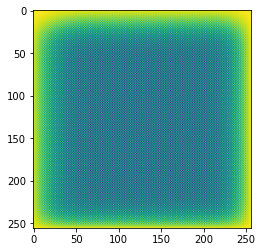

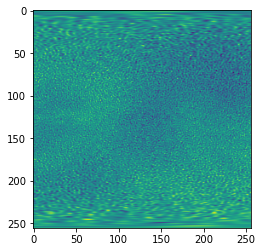

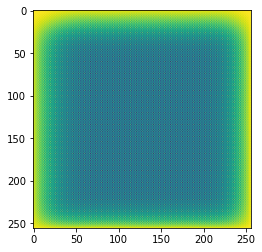

100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


------------------------------
Train Loss EPOCH 10: 4.8688
Valid Loss EPOCH 10: -0.0291
------------------------------


In [123]:
LEARNING_RATE = 3e-3
BATCH_SIZE = 1
EPOCHS = 10
DATA_PATH = "Machine_Learning/data"
MODEL_SAVE_PATH = "Machine_Learning/models/unet.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = CMB_Dataset(DATA_PATH)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Input channels = 9 (9 frequencies)
model = UNet(in_channels=9, num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
       
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_loader)):
            img = img_mask[0].to(device)
            mask = img_mask[1].to(device)
            
            # Visualize the result 
            plt.imshow(mask.squeeze().cpu().detach().numpy())
            plt.show()
            y_pred = model(img)
            plt.imshow(y_pred[0].squeeze().cpu().detach().numpy())
            plt.show()
            
            loss = criterion(y_pred, mask)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print("-"*30)


torch.save(model.state_dict(), MODEL_SAVE_PATH)


### 6.3 Using the model

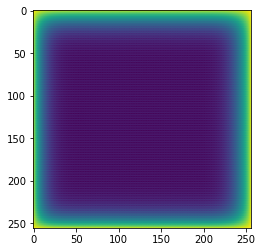

In [105]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

def load_model(model_path, device):
    model = UNet(in_channels=9, num_classes=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def preprocess_input(image_paths):

    img = np.load(image_paths).swapaxes(0,1).swapaxes(1,2)
    
    # Convert to tensor and apply any necessary transforms (e.g., normalization)
    transform = transforms.ToTensor()
    input_tensor = transform(img).float()
    
    # # Add a batch dimension if only a single image is processed
    input_tensor = input_tensor.unsqueeze(0)
    return input_tensor

def inference(model, input_tensor, device):
    # Ensure tensor is on the correct device
    input_tensor = input_tensor.to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)
        
    
    return output.squeeze().cpu().numpy()

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "Machine_Learning/models/unet.pth"  # Adjust path as needed
model = load_model(model_path, device)

# Example usage
image_paths = "Machine_Learning/data/train_data/CMB_Free_MW_Map_F9_L32_R0000.npy"
input_tensor = preprocess_input(image_paths)
predictions = inference(model, input_tensor, device)

plt.imshow(predictions)


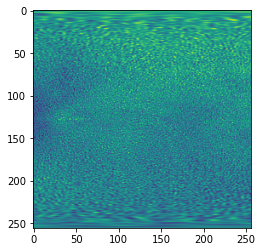

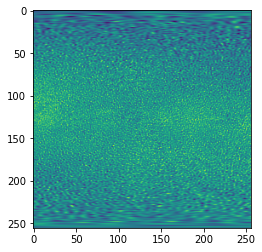

In [120]:
CMB_Free = np.load("data/train_data/CMB_Free_MW_Map_F9_L32_R0000.npy")

CMB_residual = np.load("data/train_masks/CMB_Residual_MW_Map_F100_L32_R0001.npy")
plt.imshow(CMB_residual)
plt.show()
F9 = np.load("data/train_data/CMB_Free_MW_Map_F9_L32_R0000.npy").swapaxes(0,1).swapaxes(1,2)
plt.imshow(F9[:,:,4])
plt.show()